## DATABASE CLASS
_Represent the database create from the dataset of samples_

In [13]:
from __future__ import division

import sys
import os
import h5py
import glob
import tqdm
import parmap
import time 
import pickle
from itertools import repeat
from texttable import Texttable
import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt
import multiprocessing as mp
from sklearn import model_selection,preprocessing
import imageio
from sklearn.model_selection import train_test_split
from PIL import Image

# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

from dataset import Dataset
from sample import Sample


class Database(Dataset):
    # Attributes
    __train, __test = None, None
    __train_test_file = 'train_test.pickle'
    # Initializer
    def __init__(self, dataset_location, database_location, site):
        self.__database_location = database_location
#         super(Database, self).__init__(dataset_location, site)
        super().__init__(dataset_location, site)

    def get_database_location(self):
        return self.__database_location
    
    def create_param_db(self, sample):
        sample_obj = Sample(self.get_dataset_location(), self.get_site(), sample)
        file_name = os.path.join(self.__database_location,self.get_site(), self.get_site()+'.out')
        file = h5py.File(file_name, 'w')
        temp = np.array([]) 
        file_dataset = file.create_dataset(file_name, temp.shape, np.float32, compression='gzip', data=temp)
        for key, val in sample_obj.get_spectrogram_params().items():
            file_dataset.attrs[key] = val        
        file.close()
    
    def train_test_split(self ,train_size=None, test_size=None, random_state=None, shuffle=True, save=False):
        self.__train, self.__test = train_test_split(self.get_samples(),train_size=train_size, test_size=test_size, random_state=random_state, shuffle=shuffle)
        if save:
            samples = {
                'train': self.__train,
                'test': self.__test
            }
            path = os.path.join(self.__database_location,self.get_site())
            try:
                os.makedirs(path)
            except OSError:
                pass
            pickle.dump(samples, open(os.path.join(path,self.__train_test_file), 'wb'))
    
    def train_test_load(self):
        path = os.path.join(self.__database_location,self.get_site(), self.__train_test_file)
        if not os.path.exists(path):
            raise Exception('%s does not exists.\n Generate the train_test file first.'%path)
        samples = pickle.load( open(path, "rb")) 
        self.__train = samples['train']
        self.__test = samples['test']
    
    def train_test_load_random_sample(self, test=False):
        return np.random.choice(self.get_test()) if test else np.random.choice(self.get_train())
    
    def get_train(self):
        if not self.__train:
            self.train_test_load()
        return self.__train
    
    def get_test(self):
        if not self.__test:
            self.train_test_load()
        return self.__test
        
    def create_cut_img_db(self, sample, path, transforms, transforms_params, noise=True):
        '''Create jpg cut files from a single file'''
        sample_obj = Sample(self.get_dataset_location(), self.get_site(), sample)
        sample_obj.apply_transform(transforms, transforms_params)
        # cuts of 1s and 10kHz
        cuts, whistler_count, cuts_count = sample_obj.cuts(cut_time=1, cut_freq=10, threshold=0, noise=noise)
    
        sample_obj.to_img()
        img = sample_obj.get_image()
        height = img.size[1]
        for cut, ix in zip(cuts, range(cuts_count)) :
            file_name = os.path.join(path,
                                        os.path.splitext(sample)[0]+'.cut_nbr:'+"{:02d}".format(ix+1)+'.evt:'+str(ix<whistler_count)+'.['+str(cut[0])+':'+str(cut[1])+','+str(cut[2])+':'+str(cut[3])+'].jpg')
            spec = img.crop(box=(cut[2],height-cut[1],cut[3],height-cut[0]))
            plt.figure();plt.imshow(spec);plt.show();
            spec.save(file_name)
    
    def create_cut_img_db_(self, args):
        sample, transforms, transforms_params, noise, path = args[0], args[1], args[2], args[3], args[4]
        self.create_cut_img_db(sample,transforms=transforms, transforms_params=transforms_params, noise=noise, path=path)
        
    def create_cuts_img_db_mp(self, transforms, transforms_params, noise=True, train=True, test=True, verbose=True):
        '''Parallel implementation of create_cuts_dp'''
        self.train_test_load()
        if train:
            samples = self.__train
            samples_len = len(samples)
            path = os.path.join(self.__database_location,self.get_site(), self.get_site()+'_image_cuts', 'train')
            try:
                os.makedirs(path)
            except OSError:
                pass
            pool = mp.Pool(mp.cpu_count())
            if verbose:
                # wrap arguments and use create_cut_db_ instead of create_cut_db
                samples = [[sample,transforms, transforms_params, noise, path] for sample in samples]
                for _ in tqdm.tqdm(pool.imap_unordered(self.create_cut_img_db_, samples), total=len(samples)):
                    pass
            else:
                pool.map_async(self.create_cut_img_db, samples, transforms=transforms, transforms_params=transforms_params, noise=noise, path=path)
            pool.close()
        if test:
            samples = self.__test
            samples_len = len(samples)
            path = os.path.join(self.__database_location,self.get_site(), self.get_site()+'_image_cuts', 'test')
            try:
                os.makedirs(path)
            except OSError:
                pass
            pool = mp.Pool(mp.cpu_count())
            if verbose:
                # wrap arguments and use create_cut_db_ instead of create_cut_db
                samples = [[sample,transforms, transforms_params, noise, path] for sample in samples]
                for _ in tqdm.tqdm(pool.imap_unordered(self.create_cut_img_db_, samples), total=len(samples)):
                    pass
            else:
                pool.map_async(self.create_cut_img_db, samples, transforms=transforms, transforms_params=transforms_params, noise=noise, path=path)
            pool.close()
            
        # create params output file
        self.create_param_db(samples[0])
        
    def create_cut_db(self, sample,path, transforms, transforms_params, cut_params, noise=True):
        '''Create a database from a single file'''
        sample_obj = Sample(self.get_dataset_location(), self.get_site(), sample)
        sample_obj.apply_transform(transforms, transforms_params)
        # cuts of 1s and 10kHz
#         cuts, whistler_count, cuts_count = sample_obj.cuts(cut_time=1, cut_freq=10, threshold=0, noise=noise)
        cuts, whistler_count, cuts_count = sample_obj.cuts(cut_time=cut_params[0], cut_time_split=cut_params[1],
                                                           cut_freq=cut_params[2],cut_freq_min=cut_params[3], time_err=cut_params[2], noise=noise)
        for cut, ix in zip(cuts, range(cuts_count)) :
            file_name = os.path.join(path,
                                        os.path.splitext(sample)[0]+'.cut_nbr:'+"{:02d}".format(ix+1)+'.evt:'+str(ix<whistler_count)+'.['+str(cut[0])+':'+str(cut[1])+','+str(cut[2])+':'+str(cut[3])+'].h5')
            file = h5py.File(file_name, 'w')
            spec = np.array(sample_obj.get_spectrogram()[cut[0]:cut[1],cut[2]:cut[3]])
            file_dataset = file.create_dataset(file_name, spec.shape, np.float32, compression='gzip', data=spec)
            file_dataset.attrs['target'] = ix<whistler_count
            file.close()
    
    def create_cut_db_(self, args):
        sample,transforms, transforms_params, cut_params, noise, path = args[0], args[1], args[2], args[3], args[4], args[5]
        self.create_cut_db(sample,transforms=transforms, transforms_params=transforms_params, cut_params=cut_params, noise=noise, path=path)
    

    def create_cuts_db_mp(self, transforms, transforms_params,cut_params, verbose=True, noise=True, train=True, test=True):
        '''Parallel implementation of create_cuts_dp'''
        self.train_test_load()
        if train:
            samples = self.__train
            samples_len = len(samples)
            path = os.path.join(self.__database_location,self.get_site(), self.get_site()+'_h5',
                                str(transforms)+'_'+str(transforms_params)+'_'+str(cut_params)+'_'+str(noise),'train')
            try:
                os.makedirs(path)
            except OSError:
                pass
            pool = mp.Pool(mp.cpu_count())
            if verbose:
                # wrap arguments and use create_cut_db_ instead of create_cut_db
                samples = [[sample, transforms, transforms_params, cut_params, noise, path] for sample in samples]
                for _ in tqdm.tqdm(pool.imap_unordered(self.create_cut_db_, samples), total=len(samples)):
                    pass
            else:
                pool.map_async(self.create_cut_db, samples, transforms=transforms, transforms_params=transforms_params, cut_params=cut_params, noise=noise, path=path)
            pool.close()
        if test:
            samples = self.__test
            samples_len = len(samples)
            path = os.path.join(self.__database_location,self.get_site(), self.get_site()+'_h5',
                                str(transforms)+'_'+str(transforms_params)+'_'+str(cut_params)+'_'+str(noise),'test')
            try:
                os.makedirs(path)
            except OSError:
                pass
            pool = mp.Pool(mp.cpu_count())
            if verbose:
                # wrap arguments and use create_cut_db_ instead of create_cut_db
                samples = [[sample, transforms, transforms_params,cut_params, noise, path] for sample in samples]
                for _ in tqdm.tqdm(pool.imap_unordered(self.create_cut_db_, samples), total=len(samples)):
                    pass
            else:
                pool.map_async(self.create_cut_db, samples, transforms=transforms, transforms_params=transforms_params, cut_params=cut_params, noise=noise, path=path)
            pool.close()
        # create params output file
        self.create_param_db(samples[0])
    
    def load_cut_db(self, sample):
        '''Load one cut from the database'''
        try:
            file = h5py.File(sample, 'r+')
        except Exception as e:
            print('File: %s. Exception: %s'%(sample,e))
        file_data = np.empty(file[sample].shape,dtype=np.float64)
        file[sample].read_direct(file_data)
        cut = np.asarray(file_data)
        target = file[sample].attrs['target']
        file.close()
#         print(sample)
        return np.array(cut), target
    
    def load_cut_img_db(self, sample):
        '''Load one cut from the database'''
        cut = image.imread(sample)
        target = 0 if sample.split('.[')[0].split('evt:')[1]=='False' else 1
        return cut, target

    def load_cuts_db_mp(self, transforms, transforms_params,cut_params, noise=True, verbose=True, test=False, shuffle=True, random_state=42):
        ''''''
        try:
            directory = 'test' if test else 'train'
            path = os.path.join(self.__database_location,self.get_site(), self.get_site()+'_h5',
                                             str(transforms)+'_'+str(transforms_params)+'_'+str(cut_params)+'_'+str(noise), directory)
#             samples = glob.glob(path)
            samples = [os.path.join(path,file) for file in os.listdir(path) if os.path.splitext(file)[1]=='.h5']
            print(path)
#             print(samples)
            print('samples: ',len(samples))
        except OSError as e:
            print(e)
            return None, None
        pool = mp.Pool(mp.cpu_count())
        if verbose:
            results = []
            for result in tqdm.tqdm(pool.imap_unordered(self.load_cut_db, samples), total=len(samples)):
                try:
                    results.append(result)
                except Exception as e:
                    print(e)
            results = np.array(results)
        else:
            results = np.array(pool.map_async(self.load_cut_db, samples).get())
        pool.close()
        pool.join()
        data, targets = np.array(list(results[:,0])), np.array(results[:,1])
        if shuffle:
            data = list(zip(data,targets))
            np.random.seed(random_state)
            np.random.shuffle(data)
            data, targets = zip(*data)
            data, targets = np.array(data), np.array(targets)
        return data, targets


    def load_cuts_img_db_mp(self, verbose=True, test=False, shuffle=True, random_state=42):
        ''''''
        try:
            directory = 'test' if test else 'train'
            samples = glob.glob(os.path.join(self.__database_location,self.get_site(), self.get_site()+'_image_cuts', directory,  '*.jpg'))
        except OSError as e:
            return None, None
        pool = mp.Pool(mp.cpu_count())
        if verbose:
            results = []
            for result in tqdm.tqdm(pool.imap_unordered(self.load_cut_img_db, samples), total=len(samples)):
                results.append(result)
            results = np.array(results)
        else:
            results = np.array(pool.map_async(self.load_cut_img_db, samples).get())
        pool.close()
        pool.join()
        data, targets = np.array(list(results[:,0])), np.array(results[:,1])
        if shuffle:
            data = list(zip(data,targets))
            np.random.seed(random_state)
            np.random.shuffle(data)
            data, targets = zip(*data)
            data, targets = np.array(data), np.array(targets)
        return data, targets
    
    def load_cuts_params(self):
        file_name = os.path.join(self.__database_location,self.get_site(), self.get_site()+'.out')
        file = h5py.File(file_name, 'r+')
        params = {}
        for key,val in file[file_name].attrs.items():
            params[key] = val
        file.close()
        return params
    
    def stats(self, transforms, transforms_params, cut_params,noise=True, test=False, img=False):
        '''Database stats'''
        cuts, targets = self.load_cuts_img_db_mp(test=test) if img else self.load_cuts_db_mp(transforms, transforms_params, cut_params, noise,test=test)
        temp_cuts = []
        temp_cuts.append([cut.flatten() for cut in cuts])
        temp_cuts = np.array(temp_cuts).flatten()
        counts = np.bincount(targets)
        counts_per = np.round(np.bincount(targets)*100/len(targets),2)
        
        table = Texttable()
        table.set_deco(Texttable.HEADER)
        table.set_header_align(['l','m'])
        table.header(['Database statistics', ''])
        table.set_cols_align(['l','l'])
        table.set_cols_valign(['m','m'])
        table.add_rows([
                ['min',temp_cuts.min()],
                ['max',temp_cuts.max()],
                ['mean',temp_cuts.mean()],
                ['std',temp_cuts.std()],
                ['noise', str(counts[0])+'['+str(counts_per[0])+'%]'],
                ['whistler', str(counts[1])+'['+str(counts_per[1])+'%]'],
                ['total', len(targets)]], header=False)
        print('\n'+ table.draw() + '\n')
        return cuts, targets
    
    def whistler_mean(self, transforms, transforms_params, cut_time, cut_time_split, cut_freq, cut_freq_min, time_err):
        X, _ = self.load_cuts_db_mp(transforms=transforms, transforms_params=transforms_params,cut_params=[cut_time,cut_time_split,cut_freq,cut_freq_min,time_err], noise=False, test=False)
        X_mean = np.mean(X, axis=0)
        return X_mean
    
    def whistler_mean_full(self, sample, transforms, transforms_params, cut_time, cut_time_split, cut_freq, cut_freq_min, time_err):
        data = self.whistler_mean(transforms, transforms_params, cut_time, cut_time_split, cut_freq, cut_freq_min, time_err)
        time_res, freq_res, freq_len = sample.get_time_res(),sample.get_freq_res(), len(sample.get_freq())
        data = np.array(data)
        full_data = np.full(( freq_len,int(cut_time/time_res)),data.min())
        whistler_freq_start = int(cut_freq_split*cut_freq)
        full_data[int(whistler_freq_start/freq_res):int(whistler_freq_start/freq_res)+data.shape[0],:data.shape[1]] = data
        full_data = (full_data-full_data.min())/(full_data.max()-full_data.min())*(1e3)
        return full_data
    
    def augmented_events(self, transforms, transforms_params, cut_time, cut_time_split, cut_freq, cut_freq_min, time_err,test,noise):
        X, Y = self.load_cuts_db_mp(transforms=transforms, transforms_params=transforms_params,cut_params=[cut_time,cut_time_split,cut_freq,cut_freq_min,time_err], noise=noise, test=test)
        aug_X, aug_Y = [], []
        _X, _Y = [], []
        for x,y in zip(X,Y):
            if y == True:
                aug_X.append(np.flip(x,0))
                aug_Y.append(2)
                aug_X.append(np.flip(x,1))
                aug_Y.append(3)
                aug_X.append(np.flip(np.flip(x,0),1))
                aug_Y.append(4)
            _X.append(np.flip(np.flip(x,0),0))
            _Y.append(y)
        return np.array(_X), np.array(_Y), np.array(aug_X), np.array(aug_Y)
    
    def augmented_data(self,X,Y,aug_X,aug_Y):
        X = np.concatenate((X,aug_X))
        Y = np.concatenate((Y,aug_Y))
        Z = list(zip(X,Y))
        np.random.shuffle(Z)
        X,Y = zip(*Z)
        return np.array(X), np.array(Y)
    
    def sample_to_yolo_(self, params):
        file = params[0]
        path = params[1]
        self.sample_to_yolo(file, path)
        
    def sample_to_yolo(self, file, path):
        # generate spectrogam and apply preprocessing if necessary
        sample = Sample(self.get_dataset_location(), self.get_site(), file)
        sample.spectrogram_with_axis()
        sample.apply_zscore()
        # get and save image
        data = sample.get_spectrogram()
        data = ((data-data.min())/(data.max()-data.min()))*255
        data = data.astype(np.uint8)
        data_img = Image.fromarray(data, mode='L').transpose(Image.FLIP_TOP_BOTTOM)
        title, ext = os.path.splitext(os.path.basename(file))
        data_img.save(os.path.join(path,title+'.jpg'))
        # get output
        sample.cuts()
        
    def to_img(self):
        """Convert all sample to jpg images"""
        files = self.get_samples()
        path = os.path.join(self.__database_location,self.get_site(), self.get_site()+'_image')
        try:
            os.makedirs(path)
        except OSError:
            pass
        # use multiprocessing
        pool = mp.Pool(mp.cpu_count())
        params = [[file, path] for file in files][:10] # define parameters
        for _ in tqdm.tqdm(pool.imap_unordered(self.sample_to_yolo_, params), total=len(params)):
            pass
        pool.close()
        

In [14]:
dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'marion'
my_database = Database(dataset_loc, database_loc, site)
my_database.to_img()




  0%|          | 0/10 [00:00<?, ?it/s]

(array([[ 16,  64, 532, 640],
       [ 16,  64, 532, 640],
       [ 16,  64, 532, 640],
       [ 16,  64, 532, 640],
       [ 16,  64,   0, 108],
       [ 16,  64, 108, 216],
       [ 16,  64, 216, 324],
       [ 16,  64, 324, 432]]), 4, 8)





 10%|█         | 1/10 [00:00<00:01,  6.79it/s]

(array([[ 16,  64, 349, 457],
       [ 16,  64, 351, 459],
       [ 16,  64,   0, 108],
       [ 16,  64, 108, 216],
       [ 16,  64, 216, 324],
       [ 16,  64, 459, 567]]), 2, 6)





 20%|██        | 2/10 [00:00<00:01,  5.48it/s]

(array([[ 16,  64, 350, 458],
       [ 16,  64, 358, 466],
       [ 16,  64,   0, 108],
       [ 16,  64, 108, 216],
       [ 16,  64, 216, 324],
       [ 16,  64, 466, 574]]), 2, 6)
(array([[ 16,  64, 338, 446],
       [ 16,  64, 344, 452],
       [ 16,  64, 348, 456],
       [ 16,  64, 351, 459],
       [ 16,  64, 356, 464],
       [ 16,  64, 361, 469],
       [ 16,  64, 364, 472],
       [ 16,  64, 369, 477],
       [ 16,  64, 370, 478],
       [ 16,  64, 377, 485],
       [ 16,  64, 380, 488],
       [ 16,  64, 425, 533],
       [ 16,  64, 432, 540],
       [ 16,  64, 441, 549],
       [ 16,  64,   0, 108],
       [ 16,  64, 108, 216],
       [ 16,  64, 216, 324]]), 14, 17)





 40%|████      | 4/10 [00:00<00:00,  6.94it/s]

(array([[ 16,  64, 346, 454],
       [ 16,  64, 465, 573],
       [ 16,  64, 482, 590],
       [ 16,  64, 484, 592],
       [ 16,  64,   0, 108],
       [ 16,  64, 108, 216],
       [ 16,  64, 216, 324],
       [ 16,  64, 592, 700]]), 4, 8)(array([[ 16,  64, 348, 456],
       [ 16,  64, 378, 486],
       [ 16,  64, 428, 536],
       [ 16,  64, 440, 548],
       [ 16,  64,   0, 108],
       [ 16,  64, 108, 216],
       [ 16,  64, 216, 324],
       [ 16,  64, 548, 656]]), 4, 8)
(array([[ 16,  64, 335, 443],
       [ 16,  64, 344, 452],
       [ 16,  64, 358, 466],
       [ 16,  64,   0, 108],
       [ 16,  64, 108, 216],
       [ 16,  64, 216, 324],
       [ 16,  64, 466, 574]]), 3, 7)

(array([[  16,   64,  112,  220],
       [  16,   64,  348,  456],
       [  16,   64,    0,  108],
       [  16,   64,  456,  564],
       [  16,   64,  564,  672],
       [  16,   64,  672,  780],
       [  16,   64,  780,  888],
       [  16,   64,  888,  996],
       [  16,   64,  996, 1104],
       [




100%|██████████| 10/10 [00:00<00:00,  9.41it/s]

In [2]:
# from sklearn import model_selection,preprocessing
# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# site = 'marion'
# my_database = Database(dataset_loc, database_loc, site)
# transforms = ['zscore']
# transforms_params = [[None]]
# my_database.create_cuts_db_mp(transforms=transforms, transforms_params=transforms_params,
#                               cut_params=[0.7,0.3,7.5,2.5,0.3], verbose=True, noise=True, train=True, test=True)
# # data, targets = my_database.load_cuts_db_mp(transforms=['zscore'], transforms_params=[[None]], verbose=True, noise=True, test=False)
# # X_mean = my_database.whistler_mean(transforms=['zscore'], transforms_params=[[None]], cut_time=0.7, cut_time_split=0.3, cut_freq=7.5,cut_freq_min=2.5, time_err=0.3)
# # plt.figure(figsize=(4,2)); plt.pcolormesh(X_mean, cmap='jet');plt.title('Mean');plt.show()

# # X, Y, _X, _Y = my_database.augmented_events(transforms=['zscore'], transforms_params=[[None]], cut_time=0.7, cut_time_split=0.3, cut_freq=7.5,cut_freq_min=2.5, time_err=0.3,noise=True, test=False)
# # __X, __Y = my_database.augmented_data(X,Y,_X,_Y)

100%|██████████| 725/725 [00:30<00:00, 23.46it/s]


In [59]:
# from sample_detector import SampleDetector
# from PIL import Image
# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# site = 'marion'
# my_database = Database(dataset_loc, database_loc, site)
# my_sample = SampleDetector(dataset_loc, site, np.random.choice(my_database.get_train(),1)[0])
# X_mean = my_database.whistler_mean_full(my_sample,transforms=['zscore'], transforms_params=[[None]], cut_time=0.8, cut_time_split=0.3, cut_freq=20,cut_freq_split=0, time_err=0.3)

/home/othniel/wdml/data/databases/awdEvents1/marion/marion_h5/['zscore']_[[None]]_[0.8, 0.3, 20, 0, 0.3]_False/train
samples:  1471


100%|██████████| 1471/1471 [00:02<00:00, 594.64it/s]


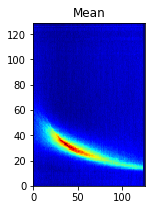

0.0 100.48860300181428 1000.0


In [60]:
# plt.figure(figsize=(2,3)); plt.pcolormesh(X_mean, cmap='jet');plt.title('Mean');plt.show()
# print(X_mean.min(),X_mean.mean(),X_mean.max())